In [1]:
import os
import sys

ENV = 'colab'
# ENV = 'local' if os.environ.get('COLAB') else 'colab'

if ENV == 'colab':
  # for running on google drive:
  from google.colab import drive
  drive.mount("/content/drive/", force_remount=True)

  !pip install fvcore -q
  !pip install -e "/content/drive/My Drive/Bayes-Stochastic-Depth" -q

  module_dir = "/content/drive/My Drive/Bayes-Stochastic-Depth/src"
  # append local module to path
  module_path = os.path.abspath(os.path.join(module_dir))
  if module_path not in sys.path:
      sys.path.append(module_path)

  data_dir = "/content/drive/My Drive/Bayes-Stochastic-Depth/data"

elif ENV == 'local':
  data_dir = "./data"

Mounted at /content/drive/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


In [2]:
from typing import Any, Callable, List, Optional, Type, Union, Tuple, Dict
from torch import Tensor

import torch
from torch import nn, optim, mps
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
import copy
from tqdm import tqdm

from models import resnet
from data import load_CIFAR
from visualization import show_cifar_images
from utils import (
    AccuracyMetric,
    get_confusion_matrix,
    count_FLOPS,
    count_parameters,
    calculate_storage_in_mb,
    bayes_eval,
    bayes_forward,
    parse_loss,
    parse_scheduler,
    get_dataset_classes
)

## Prepare dataset

### Note on moving dataset into memory:

Since the entire CIFAR dataset (train + val + test) is around 180 MB, this can easily fit onto the GPU directly & speed up training a lot.

**Comparison**
* Training time (per epoch) with data stored on CPU: `60s`
* Everything on MPS: `40s`

In [3]:
# some global variables
classes = get_dataset_classes("cifar10")

FILL_PIX = None

DEVICE = torch.device("cpu")
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")

# overwrite device:
# DEVICE = torch.device("cpu")
print(f'Using Device {DEVICE}')

datasets = load_CIFAR(data_dir, DEVICE)

Using Device cuda:0
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 10000/10000 [00:03<00:00, 2565.51it/s]


### Preview images

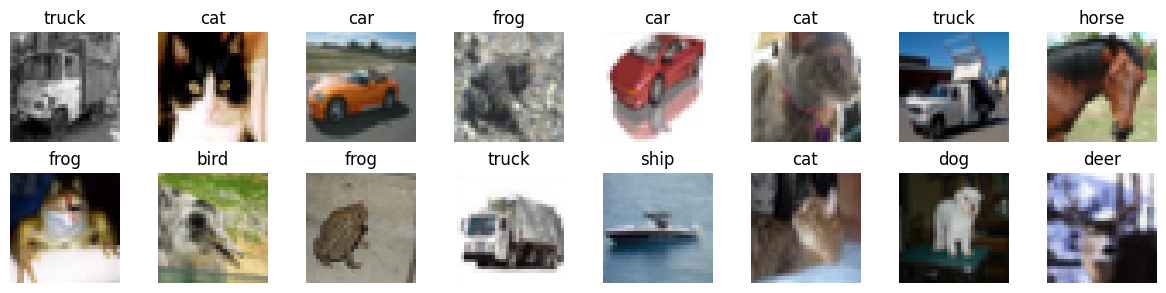

In [4]:
show_cifar_images(dataset=datasets['val'], grid_size=(2, 8), show_labels=True)

# to show images with predictions:
# show_cifar_images((2, 8), show_labels=True, dataset=testset, preds=preds)

## ResNet preview

In [6]:
resnet18 = resnet("resnet18", num_classes=10)

# load resnet18 pretrained on ImageNet
# resnet18_torch = torchvision.models.resnet.resnet18(num_classes=10)

print(f"Number of parameters: {count_parameters(resnet18, print_table=False)/1e6 :.3f} M")
print(f"Parameter in MB: {calculate_storage_in_mb(resnet18):.3f}")
print(f"Number of expected layers: {resnet18.expected_layers()}")
# print(f"Number of FLOPS: {count_FLOPS(resnet18, input_dim=(32, 32))/1e9:.3f} GFLOPS")

# dummy_input = torch.randn(16, 3, 32, 32)
# dummy_output = resnet18(dummy_input)

del(resnet18)

Number of parameters: 11.182 M
Buffer size: 0.037 MB
Parameter in MB: 42.691
Number of expected layers: 18.0


## Training Manager

In [9]:
class TrainingManager:
    def __init__(self, config, datasets):
        self.datasets = datasets
        self.config = config

        self._load()

    def _load(self) -> None:
        # read config
        self.dataset = self.config.get("dataset", "CIFAR10")
        self.classes = get_dataset_classes(self.dataset)
        self.num_classes = len(self.classes)
        self.T = self.config.get("T", 10)
        self.batch_size = self.config.get("batch_size", 16)
        self.input_dim = self.config.get("input_dim", (32, 32))
        self.total_epochs = self.config.get("total_epochs", 100)
        self.weight_decay = self.config.get("weight_decay", 1e-4)
        self.baseline_lr = self.config.get("lr", 1e-4)
        self.patience = self.config.get("patience", 20)
        self.track_metrics = self.config.get("track_metrics", ["loss"])
        self.num_classes = self.config.get("num_classes", 10)

        # initiate dataloader
        self.dataloaders = {
            "train": DataLoader(
                self.datasets["train"], batch_size=self.batch_size, shuffle=True
            ),
            "val": DataLoader(self.datasets["val"], batch_size=1, shuffle=False),
            "test": DataLoader(self.datasets["test"], batch_size=1, shuffle=False),
        }

        # initiate model
        self.net = resnet(
            resnet_name=self.config["model"],
            num_classes=self.config.get("num_classes", 10),
            dropout_mode=self.config.get("dropout_mode", "none"),
            dropout_p=self.config.get("dropout_p", 0.0),
            sd_mode=self.config.get("sd_mode", "none"),
            sd_p=self.config.get("sd_p", 0.0),
        )
        self.net.to(DEVICE)

        # initiate loss function and metric
        self.criterion = parse_loss(self.config.get("loss", "CE"))
        self.metric = AccuracyMetric(metrics=['acc'], classes=self.classes)

        # initiate optimizer and scheduler
        self.optimizer = torch.optim.RMSprop(
            self.net.parameters(), weight_decay=self.weight_decay, lr=self.baseline_lr
        )
        self.scheduler = parse_scheduler(
            self.optimizer, self.config.get("scheduler", "none"), self.total_epochs
        )

        # initialize history
        self.epoch = 0
        self.history = {"lr": []}

        for split in ["train", "val", "val_b"]:
            self.history[f"loss/{split}"] = []
            self.history[f"acc/avg/{split}"] = []
            self.history[f"acc/global/{split}"] = []
            for c in self.classes:
                self.history[f"acc/{c}/{split}"] = []

        self.history["best_val_loss"] = 999
        self.history["best_val_acc"] = 0
        self.history["best_epoch"] = 0
        self.patience_count = 0

    def _check_early_stop(self, min_epochs: int = 10) -> bool:
        """
        Checks for early stop and updates best net, returns early stop state
        """
        if self.epoch < min_epochs or len(self.history["loss/val"]) <= 1:
            return False

        update_best = False
        loss = self.history["loss/val"][-1]
        acc = self.history["acc/avg/val"][-1]
        curr_min_loss = self.history.get("best_val_loss", 999)
        curr_max_acc = self.history.get("best_val_acc", 0)

        # compare loss and acc to current best
        if "loss" in self.track_metrics and loss < curr_min_loss:
            print(f"loss decreased by {(curr_min_loss-loss)/curr_min_loss*100 :.3f} %")
            self.history["best_val_loss"] = loss
            update_best = True
        if "acc" in self.track_metrics and acc > curr_max_acc:
            print(
                f"acc increased by {(acc-curr_max_acc)/(curr_max_acc+1e-16)*100 :.3f} %"
            )
            self.history["best_val_acc"] = acc
            update_best = True

        if loss > curr_min_loss and acc < curr_max_acc:
            self.patience_count += 1

        # update best net
        if update_best:
            print("saving best net...")
            self.best_net = copy.deepcopy(self.net)
            self.history["best_epoch"] = self.epoch
            self.patience_count = 0

        if self.patience_count >= self.patience:
            print(
                f"Acc(c) or miou have not improved for {self.patience} epochs, terminate training"
            )
            return True

        return False

    def evaluate(
        self,
        set: str = "test",
        bayes_mode: bool = False,
        T: Optional[int] = None,
        **kwargs,
    ) -> Tuple[float, Dict[str, float]]:
        """
        Evaluate the model on a given set
        """
        self.net.eval()  # must be called before setting bayes mode
        if bayes_mode:
            self.net.set_bayes_mode(True)
            T = self.T if T is None else T
            assert T > 0, "T must be greater than 0 if bayes_mode is True"

            h, w = self.config["input_dim"]
            buffer_tensor = torch.empty(
                size=(T, 3, h, w), dtype=torch.float32, device=DEVICE
            )
        else:
            self.net.set_bayes_mode(False)
            T = 0
            buffer_tensor = None

        loss = 0
        confusion_matrix = torch.zeros(
            (self.num_classes, self.num_classes), device=DEVICE
        )

        with torch.no_grad():
            for X_batch, y_batch in tqdm(self.dataloaders[set]):
                # force batch size to be 1
                for x, y in zip(X_batch, y_batch):
                    # forward pass
                    y_logits, y_pred = bayes_eval(self.net, x, T, buffer=buffer_tensor)
                    # compute loss
                    loss += self.criterion(y, y_logits).item()
                    # update confusion matrix
                    confusion_matrix += get_confusion_matrix(
                        y, y_pred, self.num_classes
                    )

        # compute loss and accuracy
        loss /= len(self.dataloaders[set].dataset)
        accs = self.metric(confusion_matrix)

        return loss, accs

    def train(self, epochs, eval_mode="bayes") -> None:
        """
        Main training loop
        Args:
            epochs: number of epochs to train
            eval_mode: mode to evaluate the model, can be "regular", "bayes", or "all"
        """
        torch.cuda.empty_cache()  # helps clearing RAM
        for e in range(epochs):
            self.net.train()
            # stochastic regularization should always be on during training
            self.net.set_bayes_mode(True)
            # create temporary dict to hold epoch results for train set
            train_loss = 0
            confusion_matrix = torch.zeros(
                (self.num_classes, self.num_classes), device=DEVICE
            )

            for X_batch, y_batch in tqdm(self.dataloaders["train"]):
                self.optimizer.zero_grad()
                # forward pass
                y_logits = self.net(X_batch)
                # compute loss
                loss = self.criterion(y_batch, y_logits)
                # back prop
                loss.backward()
                # update parameters
                self.optimizer.step()
                # update loss
                batch_size = X_batch.shape[0]
                train_loss += loss.item() * batch_size
                # update confusion matrix
                y_pred = torch.argmax(y_logits, 1, keepdim=False)
                confusion_matrix += get_confusion_matrix(
                    y_batch, y_pred, self.num_classes
                )
            self.scheduler.step()

            # compute average train loss and accuracy
            n_train = len(self.dataloaders["train"].dataset)
            train_loss /= n_train
            accs = self.metric(confusion_matrix)
            self._log_history("train", train_loss, accs)

            # compute validation loss and accuracy
            val_loss, val_accs, val_loss_b, val_accs_b = None, None, None, None
            if eval_mode == "regular" or eval_mode == "all":
                val_loss, val_accs = self.evaluate("val", bayes_mode=False)
            if eval_mode == "bayes" or eval_mode == "all":
                val_loss_b, val_accs_b = self.evaluate("val", bayes_mode=True)

            self._log_history("val", val_loss, val_accs)
            self._log_history("val_b", val_loss_b, val_accs_b)

            self.history["lr"].append(self.scheduler.get_last_lr()[0])

            # check for early stop
            early_stop = self._check_early_stop()
            self.epoch += 1

            # print results
            print(f"Epoch {self.epoch}")
            for name in ["train", "val"]:
                print(
                    f"{name}: Acc(g) = {self.history[f'acc/global/{name}'][-1]*100:.4f}, Acc(c) = {self.history[f'acc/avg/{name}'][-1]*100:.4f}, Loss = {self.history[f'loss/{name}'][-1]:.4f}"
                )

            if early_stop or self.epoch >= self.total_epochs:
                print("Terminate training")
                return

    def _log_history(self, set: str, loss: float, accs: Dict[str, float]) -> None:
        loss = loss if loss is not None else 0
        accs = accs if accs is not None else {}
        self.history[f"loss/{set}"].append(loss)
        for name in accs.keys():
            self.history[f"{name}/{set}"].append(accs.get(name, 0))
        return

### Result Manager

In [31]:
from visualization import (
    plot_loss_history,
    plot_acc_history,
    plot_per_class_acc_history,
)
from utils import get_dataset_classes
import json


class ResultManager:
    def __init__(
        self,
        training_manager: TrainingManager,
        directory: Optional[str] = None,
    ) -> None:
        self.training_manager = training_manager
        self.datasets = training_manager.datasets

        dataset_name = self.training_manager.config["dataset"]
        self.classes = get_dataset_classes(dataset_name)

        if directory is None:
            experiment = self.training_manager.config["experiment"]
            self.directory = f"results/{dataset_name}/{experiment}"
        else:
            self.directory = directory

    def save(self, **kwargs) -> None:
        """
        Saves the training results to self.directory
        """
        self._save_history(kwargs.pop("save_plot", True))
        self._save_config()
        self._save_net(kwargs.pop("save_best_net", False))
        self._save_results()

        return

    def _save_history(self, save_plot=True) -> None:
        """
        Saves the training history to self.directory/history.json
        """
        history = self.training_manager.history
        with open(f"{self.directory}/history.json", "w") as f:
            json.dump(history, f)
        print(f"saved history to {self.directory}/history.json")
        if save_plot:
            self.plot_history(history, save=True)

    def _save_config(self) -> None:
        """
        Saves the training config to self.directory/config.json
        """
        config = self.training_manager.config
        with open(f"{self.directory}/config.json", "w") as f:
            json.dump(config, f)
        print(f"saved config to {self.directory}/config.json")

    def _save_net(self, save_best_net=False) -> None:
        """
        Saves the trained model to self.directory/net.pt
        """
        net = self.training_manager.net
        torch.save(net.state_dict(), f"{self.directory}/model.pt")
        if save_best_net:
            best_net = self.training_manager.best_net
            torch.save(best_net.state_dict(), f"{self.directory}/best_model.pt")
        print(f"saved net to {self.directory}/net.pt")

    def _save_results(self) -> None:
        """
        Runs evaluation on test set, then saves the results to self.directory/results.json
        """
        # Retrieve information about training and validation set from history
        results = {}
        history = self.training_manager.history
        for split in ["train", "val"]:
            results[split] = {}
            for metric in ["loss", "acc/avg", "acc/global"]:
                results[split][metric] = history[f"{metric}/{split}"][-1]
            results[split]["acc"] = {}
            for c in self.classes:
                results[split]["acc"][f"{c}"] = history[f"acc/{c}/{split}"][-1]

        # Test set
        print("Evaluating on test set...")
        loss, accs = self.training_manager.evaluate("test", bayes_mode=False)
        loss_b, accs_b = self.training_manager.evaluate("test", bayes_mode=False)

        results["test"] = {
            "loss": loss,
            "acc/global": accs["acc/global"],
            "acc/avg": accs["acc/avg"],
            "accs": {},
        }
        results["test_bayes"] = {
            "loss": loss_b,
            "acc/global": accs_b["acc/global"],
            "acc/avg": accs_b["acc/avg"],
            "accs": {},
        }
        for c in self.classes:
            results["test"]["accs"][c] = accs[f"acc/{c}"]
            results["test_bayes"]["accs"][c] = accs_b[f"acc/{c}"]

        with open(f"{self.directory}/results.json", "w") as f:
            json.dump(results, f)
        print(f"saved results to {self.directory}/results.json")

    def plot_history(
        self,
        history: Optional[Dict] = None,
        classes: List[str] = None,
        save: bool = False,
    ) -> None:
        """
        Plots the training history
        ------------------------------
        Loss trainval | acc(g) trainval
        ------------------------------
        acc(c) train  | acc(c) val
        ------------------------------
        """
        if history is None:
            history = self.training_manager.history

        if classes is None:
            classes = self.classes

        assert [
            x in history.keys()
            for x in ["loss/train", "loss/val", "acc/global/train", "acc/global/val"]
        ], "history does not contain the required keys"

        plt.figure(figsize=(12, 10))
        plt.subplot(2, 2, 1)
        loss_history = {"train": history["loss/train"], "val": history["loss/val"]}
        plot_loss_history(loss_history)
        plt.title("Loss")

        plt.subplot(2, 2, 2)
        acc_history = {
            "train": history["acc/global/train"],
            "val": history["acc/global/val"],
        }
        plot_acc_history(acc_history)
        plt.title("Acc(g)")

        plt.subplot(2, 2, 3)
        per_class_acc_history = {cls: history[f"acc/{cls}/train"] for cls in classes}
        plot_per_class_acc_history(per_class_acc_history, classes)
        plt.title("Acc(c) Train")

        plt.subplot(2, 2, 4)
        per_class_acc_history = {cls: history[f"acc/{cls}/val"] for cls in classes}
        plot_per_class_acc_history(per_class_acc_history, classes)
        plt.title("Acc(c) Val")

        plt.tight_layout()

        if save:
            plt.savefig(f"{self.directory}/history.png", dpi=200)
            print(f"saved history to {self.directory}/history.png")

## Training

In [10]:
config = {
    "experiment": "tests",
    "dataset": "cifar10",  # from which we get classes separately
    "input_dim": (32, 32),
    "model": "resnet18",
    "dropout_mode": "none",
    "dropout_p": 0.0,
    "sd_mode": "none",
    "sd_p": 0.0,
    "loss": "CE",  # ["CE", "Focal"]
    "lr": 1e-4,
    "weight_decay": 1e-4,
    "scheduler": "none",  # ["poly", "exp"]
    "T": 10,
    "batch_size": 16,
    "total_epochs": 100,
    "patience": 20,
    "track_metrics": ["loss", "acc"],
}

training_manager = TrainingManager(config, datasets)

In [11]:
training_manager.train(3, eval_mode='regular')

100%|██████████| 5000/5000 [00:32<00:00, 153.43it/s]


Epoch 1
train: Acc(g) = 45.4978, Acc(c) = 45.4881, Loss = 1.5174
val: Acc(g) = 53.5600, Acc(c) = 53.6458, Loss = 1.2898


100%|██████████| 5000/5000 [00:31<00:00, 156.35it/s]


Epoch 2
train: Acc(g) = 59.6800, Acc(c) = 59.6689, Loss = 1.1402
val: Acc(g) = 62.7200, Acc(c) = 62.7889, Loss = 1.0557


100%|██████████| 5000/5000 [00:31<00:00, 156.47it/s]

Epoch 3
train: Acc(g) = 66.9622, Acc(c) = 66.9526, Loss = 0.9402
val: Acc(g) = 68.2200, Acc(c) = 68.2614, Loss = 0.9178


In [32]:
result_manager = ResultManager(training_manager)

In [ ]:
result_manager.save()

saved history to results/cifar10/tests/history.json
saved history to results/cifar10/tests/history.png
saved config to results/cifar10/tests/config.json
saved net to results/cifar10/tests/net.pt
Evaluating on test set...


100%|██████████| 10000/10000 [01:04<00:00, 155.72it/s]


saved results to results/cifar10/tests/results.json
